# <left> <font face=timenewroman color=Black size=7> SAM Algorithm </left>

<a href="
https://colab.research.google.com/github/HamedGholampour/Machine_Learning_Projects/blob/main/SAM_LaMa/SAM_LaMa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
%cd /content/drive/MyDrive/SAM

/content/drive/MyDrive/SAM


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [25]:
!nvidia-smi

Sat May 20 09:55:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |   7291MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant. 

In [26]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content/drive/MyDrive/SAM


## Install Segment Anything Model (SAM) and other dependencies

In [5]:
%cd {HOME}
import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content/drive/MyDrive/SAM
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-3hnx26aw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-3hnx26aw
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=01f1158f95be8542c03f3fa4af0131ff4d8a78b70151a116cdd1ae2b25954ce6
  Stored in directory: /tmp/pip-ephem-wheel-cache-h4ijoj4d/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [6]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 44.1 MB/s eta 0:00:00


### Download SAM weights

In [7]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content/drive/MyDrive/SAM
/content/drive/MyDrive/SAM/weights


In [27]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/drive/MyDrive/SAM/weights/sam_vit_h_4b8939.pth ; exist: True


## Download Example Data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [28]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

/content/drive/MyDrive/SAM
/content/drive/MyDrive/SAM/data


In [10]:
!wget -q /content/drive/MyDrive/SAM/Pic2.jpg

## Load Model

In [29]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [30]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [31]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [32]:
!pwd

/content/drive/MyDrive/SAM/data


In [33]:
import os

IMAGE_NAME = "Pic2.jpg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)
print(IMAGE_PATH)

/content/drive/MyDrive/SAM/data/Pic2.jpg


## Generate masks with SAM

In [34]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [35]:
print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

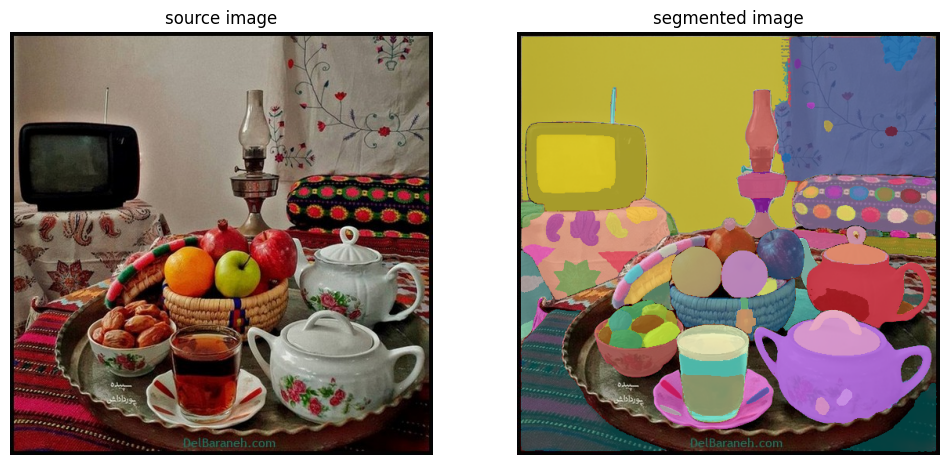

In [36]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

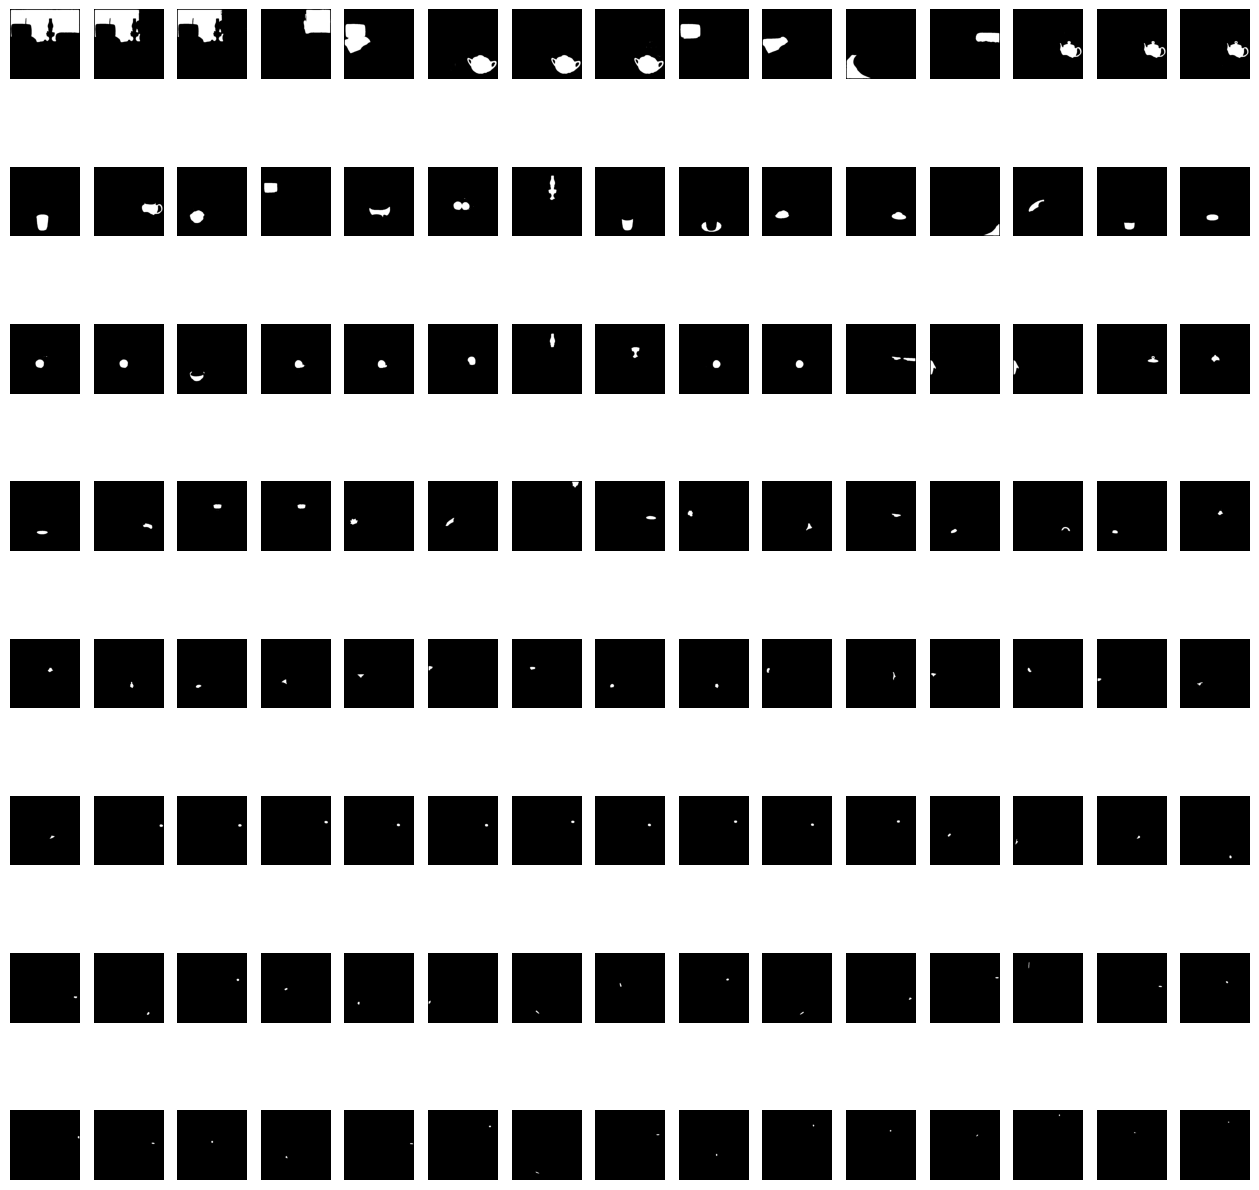

In [37]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [38]:
mask_predictor = SamPredictor(sam)

In [39]:
import os

IMAGE_NAME = "Pic2.jpg"
IMAGE_PATH = os.path.join(HOME,'data', IMAGE_NAME)
print(IMAGE_PATH)

/content/drive/MyDrive/SAM/data/Pic2.jpg


### Draw Box



In [40]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [41]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [42]:
widget.bboxes

[{'x': 93, 'y': 337, 'width': 122, 'height': 104, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [43]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']
])

In [44]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

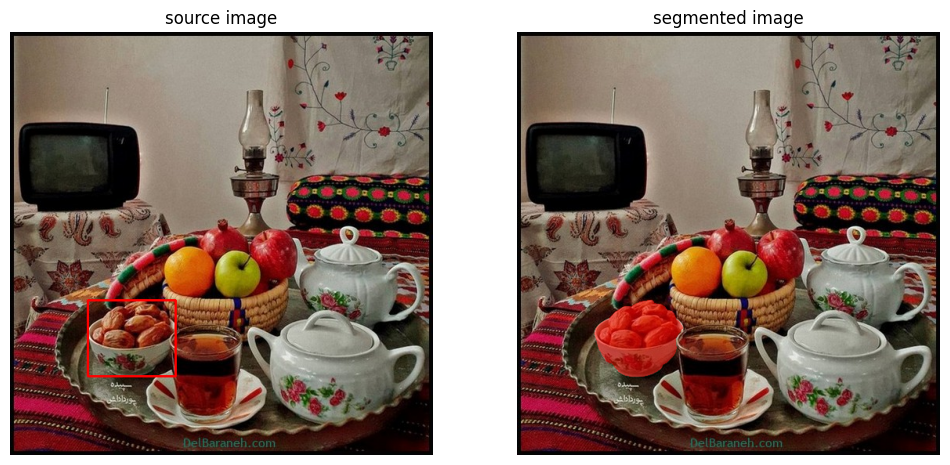

In [45]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

In [46]:
image_rgb.shape

(540, 540, 3)

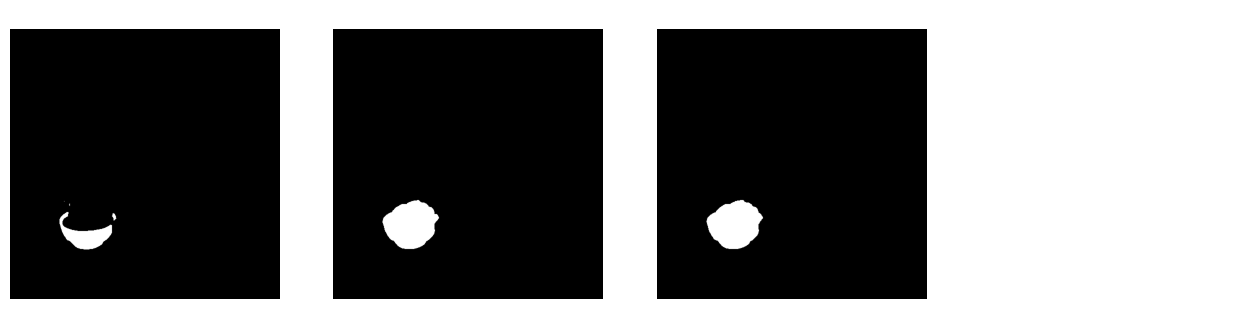

In [47]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

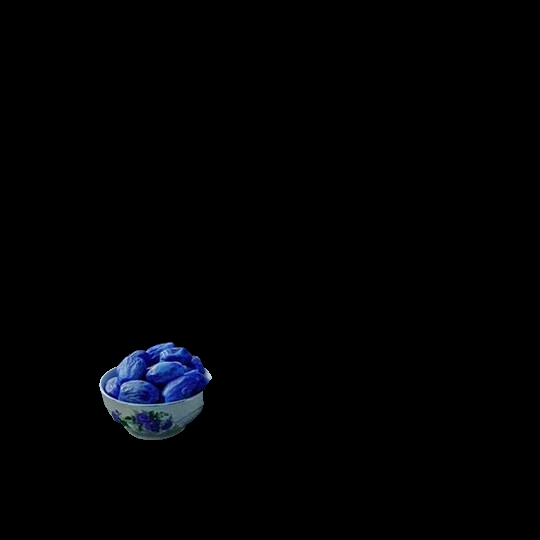

In [48]:
from google.colab.patches import cv2_imshow
q = detections.mask.copy()
q = q.astype(np.uint8)
q = q * 255
# q = cv2.bitwise_not(q) # if you want complement of image
q = q.reshape((540, 540, 1))
q = cv2.merge((q,q,q))
cv2_imshow(cv2.bitwise_and(q, image_rgb))

In [49]:
len(masks)

3

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [50]:
!pwd

/content/drive/MyDrive/SAM/data


In [51]:
%cd /content/drive/MyDrive/SAM/

/content/drive/MyDrive/SAM


In [52]:
!mkdir {HOME}/mask
%cd {HOME}/mask

/content/drive/MyDrive/SAM/mask


In [53]:
cv2.imwrite('Pic2_mask.png', q)

True

## Inpainting

In [54]:
!pwd

/content/drive/MyDrive/SAM/mask


In [55]:
%cd /content/drive/MyDrive/SAM/

/content/drive/MyDrive/SAM


In [ ]:
!git clone https://github.com/advimman/lama.git

fatal: destination path 'lama' already exists and is not an empty directory.


In [ ]:
!virtualenv inpenv --python=/usr/bin/python3
!source inpenv/bin/activate
!pip install torch==1.8.0 torchvision==0.9.0

%cd lama
!pip install -r requirements.txt 

/bin/bash: virtualenv: command not found
/bin/bash: inpenv/bin/activate: No such file or directory
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement torch==1.8.0 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.8.0
/content/drive/MyDrive/SAM/lama
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.8/29.8 MB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 104.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
!pwd

/content/drive/MyDrive/SAM/lama


In [39]:
%cd lama

/content/drive/MyDrive/SAM/lama


In [40]:
!export TORCH_HOME=$(pwd) && export PYTHONPATH=$(pwd)

In [ ]:
!pip3 install wldhx.yadisk-direct

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached wldhx.yadisk_direct-0.0.6-py3-none-any.whl (4.5 kB)


In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
!unzip big-lama.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  363M    0  363M    0     0   9.9M      0 --:--:--  0:00:36 --:--:-- 10.0M
Archive:  big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/EgqaSnLohjuzAg) -o lama-models.zip
!unzip lama-models.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 6257M    0 6257M    0     0   9.9M      0 --:--:--  0:10:26 --:--:-- 10.2M
Archive:  lama-models.zip
  inflating: LaMa_models/big-lama-with-discr/config.yaml  
  inflating: LaMa_models/big-lama-with-discr/models/best.ckpt  
  inflating: LaMa_models/big-lama/config.yaml  
  inflating: LaMa_models/big-lama/models/best.ckpt  
  inflating: LaMa_models/lama-celeba-hq-pl-abl/lama-no-pl/config.yaml  
  inflating: LaMa_models/lama-celeba-hq-pl-abl/lama-no-pl/models/best.ckpt  
  inflating: LaMa_models/lama-celeba-hq/ lama-regular/config.yaml  
  inflating: LaMa_models/lama-celeba-hq/ lama-regular/models/best.ckpt  
  inflating: LaMa_models/lama-celeba-hq/lama-deep/config.yaml  
  inflating: LaMa_models/lama-celeba-hq/lama-deep/models/best.ckpt  
  inflating

In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/xKQJZeVRk5vLlQ) -o LaMa_test_images.zip
!unzip LaMa_test_images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  118M    0  118M    0     0  10.9M      0 --:--:--  0:00:10 --:--:-- 11.1M
Archive:  LaMa_test_images.zip
  inflating: LaMa_test_images/000068.png  
  inflating: LaMa_test_images/000068_mask.png  
  inflating: LaMa_test_images/000814.png  
  inflating: LaMa_test_images/000814_mask.png  
  inflating: LaMa_test_images/1010698.png  
  inflating: LaMa_test_images/1010698_mask.png  
  inflating: LaMa_test_images/15355245546_d2a4634b16_o.png  
  inflating: LaMa_test_images/15355245546_d2a4634b16_o_mask.png  
  inflating: LaMa_test_images/16693_1.png  
  inflating: LaMa_test_images/16693_12.png  
  inflating: LaMa_test_images/16693_12_mask.png  
  inflating: LaMa_test_images/16693_1_mask.png  
  inflating: LaMa_test_images/51042170913_78f61a87af_o.png  
  

In [56]:
path = '/content/drive/MyDrive/SAM/mask/Pic2.png'
path_mask = '/content/drive/MyDrive/SAM/mask/Pic2_mask.png'
path_test = '/content/drive/MyDrive/SAM/lama/LaMa_test_images' 

In [57]:
!cp -r {path} {path_test}

In [58]:
!cp -r {path_mask} {path_test}

In [44]:
!cp -r /content/drive/MyDrive/SAM/lama/saicinpainting /content/drive/MyDrive/SAM/lama/bin

In [46]:
!cp -r /content/drive/MyDrive/SAM/lama/models /content/drive/MyDrive/SAM/lama/bin

In [45]:
%cd /content/drive/MyDrive/SAM/lama

/content/drive/MyDrive/SAM/lama


In [ ]:
!pip install numpy --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 12.4 MB/s eta 0:00:00


In [1]:
!pip install hydra-core

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
!pip install webdataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.3 MB/s eta 0:00:00


In [59]:
%cd /content/drive/MyDrive/SAM/lama

/content/drive/MyDrive/SAM/lama


In [68]:
!python /content/drive/MyDrive/SAM/lama/bin/predict.py model.path=/content/drive/MyDrive/SAM/lama/LaMa_models/big-lama-with-discr indir=/content/drive/MyDrive/SAM/lama/LaMa_test_images outdir=/content/drive/MyDrive/SAM/lama/output

Detectron v2 is not installed
/content/drive/MyDrive/SAM/lama/bin/predict.py:38: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../configs/prediction', config_name='default.yaml')
/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
  ret = run_job(
[2023-05-20 10:14:33,070][saicinpainting.utils][WARNING] - Setting signal 10 handler <function print_traceback_handler at 0x7ff562d7cb80>
[2023-05-20 10:14:34,035][root][INFO] - Make training model default
[2023-05-20 10:14:34,035][saicinpainting.training.trainers.base][INFO] - BaseInpaintingTrainingModule init called
[2023-05-20 10:14:34,036][root][INFO] - Make generator ffc_resnet
[2023-05-20 10

In [ ]:
import cv2

img = cv2.imread('/content/drive/MyDrive/SAM/data/Pic2.jpg')
cv2.imwrite('/content/lama/LaMa_test_images/Pic2.png', img)

True